# Programming Practice III

## 1 Overview
In this practice, you study the common hyperparameters of the neural network implemented in Programming Practice II. In particular, you are expected to
* comapre the training procedure and the performance of a neural network with different initialization methods, learning rates, capacities and regularization decays;
* learn to implement the techniques mentioned above from scratch with simple examples.

## 2 Tasks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 2.1 Define Neural Network

In [2]:
def print_shape(var, locals=locals()):
  pname = lambda v, names: [k for k in names if names[k] is v]
  print(f'{pname(var,locals)} shape {var.shape}')

In [3]:
# ----- useful functions from P2 -----
def create_toy_dataset(n_samples=100):
  X = np.linspace(-1,1,num=n_samples)
  Y = 0.1*X + X**2 + X**3
  X = X.reshape(1,-1)
  Y = Y.reshape(1,-1)
  return X, Y

def mse(y_true, y_pred):
  return 0.5*np.sum((y_pred-y_true)**2, axis=-1)

def derivative_mse(y_true, y_pred):
  return y_pred - y_true

def update_parameters(parameters, gradient, learning_rate):
  return parameters - learning_rate * gradient

# ----- ReLU and its derivative -----
def relu(x):
  return x*(x > 0)

def derivative_relu(x):
  return 1*(x > 0)

def forward_pass(x, w1, b1, w2, b2):
  return w2@relu(w1@x+b1) + b2

def cal_gradient(x, y, y_hat, w1, b1, w2, b2):
  dLdy_hat = derivative_mse(y, y_hat)                                  # 1 x B
  # print_shape(dLdy_hat,locals())
  y1 = w1@x + b1                                                       # n1 x B
  # print_shape(y1)
  dLdb2 = np.mean(dLdy_hat, axis=-1, keepdims=True)                    # 1 x 1
  dLdw2 = np.mean(dLdy_hat*y1, axis=-1, keepdims=True).T               # 1 x n1

  dLdy1 = (dLdy_hat.T @ w2).T                                          # 1 x n1

  dLdw1 = dLdy1 * derivative_relu(y1) * x                              # n1 x 1
  dLdw1 = np.mean(dLdw1, axis=-1, keepdims=True)
  dLdb1 = dLdy1 * derivative_relu(y1) * 1                              # n1 x 1
  dLdb1 = np.mean(dLdb1, axis=-1, keepdims=True)
  
  return dLdw1, dLdb1, dLdw2, dLdb2


In [4]:
# w1 500 x 1
# b1 500 x 1
# w2 1 x 500
# b2 1 x 1

# test
xt,yt = create_toy_dataset(10)
print_shape(xt)
w1,b1,w2,b2 = np.zeros((500,1)),np.zeros((500,1)),np.zeros((1,500)),np.zeros((1,1))
yt_h=forward_pass(xt,w1,b1,w2,b2)
dLdw1, dLdb1, dLdw2, dLdb2= cal_gradient(xt,yt,yt_h,w1,b1,w2,b2)
for shape in dLdw1, dLdb1, dLdw2, dLdb2:
  print_shape(shape)

['xt'] shape (1, 10)
['dLdw1', 'shape'] shape (500, 1)
['dLdb1', 'shape'] shape (500, 1)
['dLdw2', 'shape'] shape (1, 500)
['dLdb2', 'shape'] shape (1, 1)


In [5]:
class NeuralNetwork():
    def __init__(self, parameters, learning_rate, step):
        self.w1,self.b1,self.w2,self.b2 = parameters
        self.learning_rate = learning_rate
        self.step = step
        self.loss_log = []
    
    def train(self, x, y, epochs=5000, minibatch_num=1):
        x_, y_ = x.reshape(minibatch_num,1,-1), y.reshape(minibatch_num,1,-1)
        loss = 0
        for i in range(epochs):
          for x,y in zip(x_,y_):
            y_hat = forward_pass(x,self.w1,self.b1,self.w2,self.b2)
            loss = 1/y.shape[1]*(mse(y, y_hat))
            gradient = cal_gradient(x,y,y_hat,self.w1,self.b1,self.w2,self.b2)
            self.w1 = update_parameters(self.w1,gradient[0],self.learning_rate)
            self.b1 = update_parameters(self.b1,gradient[1],self.learning_rate)
            self.w2 = update_parameters(self.w2,gradient[2],self.learning_rate)
            self.b2 = update_parameters(self.b2,gradient[3],self.learning_rate)
          self.loss_log.append(loss)
          if(i==0 or (i+1)%self.step == 0):
            print(f'[epoch {i+1}/{epochs}], loss {loss}')
    
    def predict(self, x):
        return forward_pass(x,self.w1,self.b1,self.w2,self.b2)

### 2.2 Parameter Initialization

In [6]:
def initialize_parameters(method, num_neurons):
    random_state = np.random.RandomState(42)
    if (method == "normal"):
      # w1 = np.random.normal(0,0.1,size=(num_neurons,1))
      # w2 = np.random.normal(0,0.1,size=(1,num_neurons))
      stddev = 0.1
      w1 = stddev * random_state.randn(num_neurons,1)
      w2 = stddev * random_state.randn(1, num_neurons)
    else:
      w1 = random_state.uniform(-0.1,0.1,size=(num_neurons,1))
      w2 = random_state.uniform(-0.1,0.1,size=(1,num_neurons))
    b1 = np.zeros((num_neurons,1))
    b2 = 0
    return w1, b1, w2, b2
      

In [7]:
np.random.seed(42)
x,y = create_toy_dataset()
indx = np.random.permutation(range(x.shape[1]))
x,y = x[:,indx], y[:,indx]
num_neurons = 500
from time import time
start = time()
# train neural networks with different intialization methods
method = "normal"
print('----- initialization method: %s -----' % method)
parameters = initialize_parameters(method, num_neurons)
nn_normal = NeuralNetwork(parameters, learning_rate=0.01, step=500)
nn_normal.train(x,y,epochs=5000,minibatch_num=1)
losses_normal = nn_normal.loss_log
end = time()
print(f'training time is {end-start}\n')

method = "uniform"
print('----- initialization method: %s -----' % method)
parameters = initialize_parameters(method, num_neurons)
nn_uniform = NeuralNetwork(parameters, learning_rate=0.01, step=500)
nn_uniform.train(x,y,epochs=5000,minibatch_num=1)
losses_uniform = nn_uniform.loss_log
y_uniform = nn_uniform.predict(x)

----- initialization method: normal -----
[epoch 1/5000], loss [0.22807076]
[epoch 500/5000], loss [0.0248802]
[epoch 1000/5000], loss [0.01460914]
[epoch 1500/5000], loss [0.00992123]
[epoch 2000/5000], loss [0.00745659]
[epoch 2500/5000], loss [0.00596376]
[epoch 3000/5000], loss [0.00494369]
[epoch 3500/5000], loss [0.00418948]
[epoch 4000/5000], loss [0.00360653]
[epoch 4500/5000], loss [0.00314308]
[epoch 5000/5000], loss [0.00276934]
training time is 8.267657279968262

----- initialization method: uniform -----
[epoch 1/5000], loss [0.21804534]
[epoch 500/5000], loss [0.04668553]
[epoch 1000/5000], loss [0.03164916]
[epoch 1500/5000], loss [0.02220864]
[epoch 2000/5000], loss [0.01572213]
[epoch 2500/5000], loss [0.01191728]
[epoch 3000/5000], loss [0.00963884]
[epoch 3500/5000], loss [0.00809442]
[epoch 4000/5000], loss [0.00695438]
[epoch 4500/5000], loss [0.00607536]
[epoch 5000/5000], loss [0.00537973]


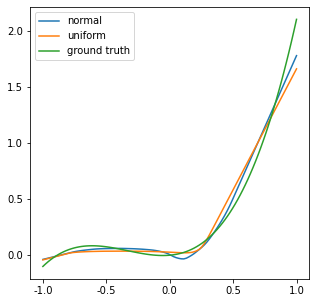

In [8]:
# visualize the results
x,y = create_toy_dataset()
y_normal = nn_normal.predict(x)
y_uniform = nn_uniform.predict(x)
plt.figure(figsize=(5,5))
plt.plot(x[0,:], y_normal[0,:],label='normal')
plt.plot(x[0,:], y_uniform[0,:],label='uniform')
plt.plot(x[0,:], y[0,:],label='ground truth')
plt.xticks(ticks=np.linspace(-1, 1, 5), labels=np.linspace(-1, 1, 5))
plt.legend()
plt.show()

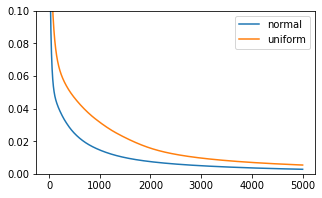

In [9]:
plt.figure(figsize=(5,3))
plt.plot(losses_normal, label='normal')
plt.plot(losses_uniform, label='uniform')
plt.ylim([0,0.1])
plt.legend()
plt.show()

### 2.3 Learning Rate

In [10]:
# train neural networks with different learning rates
x, y = create_toy_dataset()
learning_rate_set = [np.power(0.1,i) for i in range(1,6)]
loss_results = []
prediction_results = []

num_neurons = 500
parameters = initialize_parameters('normal',num_neurons)
for lr in learning_rate_set:
  print(f'-----learning rate: {lr:.5f} ------')
  nn = NeuralNetwork(parameters,lr,step=500)
  nn.train(x,y,epochs=5000)
  loss_results.append(nn.loss_log)
  prediction_results.append(nn.predict(x))

-----learning rate: 0.10000 ------
[epoch 1/5000], loss [0.22807076]
[epoch 500/5000], loss [0.00276931]
[epoch 1000/5000], loss [0.00113909]
[epoch 1500/5000], loss [0.00065602]
[epoch 2000/5000], loss [0.00044026]
[epoch 2500/5000], loss [0.00032916]
[epoch 3000/5000], loss [0.00026208]
[epoch 3500/5000], loss [0.00021673]
[epoch 4000/5000], loss [0.00018317]
[epoch 4500/5000], loss [0.00015689]
[epoch 5000/5000], loss [0.00013557]
-----learning rate: 0.01000 ------
[epoch 1/5000], loss [0.22807076]
[epoch 500/5000], loss [0.0248802]
[epoch 1000/5000], loss [0.01460914]
[epoch 1500/5000], loss [0.00992123]
[epoch 2000/5000], loss [0.00745659]
[epoch 2500/5000], loss [0.00596376]
[epoch 3000/5000], loss [0.00494369]
[epoch 3500/5000], loss [0.00418948]
[epoch 4000/5000], loss [0.00360653]
[epoch 4500/5000], loss [0.00314308]
[epoch 5000/5000], loss [0.00276934]
-----learning rate: 0.00100 ------
[epoch 1/5000], loss [0.22807076]
[epoch 500/5000], loss [0.07332641]
[epoch 1000/5000], l

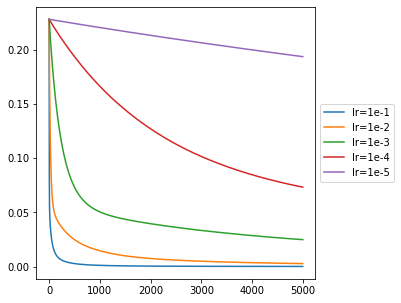

In [11]:
# visualize the results
plt.figure(figsize=(5,5))
for idx, lr in enumerate(learning_rate_set):
  plt.plot(loss_results[idx], label=f'lr=1e-{idx+1}')
plt.legend(bbox_to_anchor=(1,0.5),loc='center left')
plt.show()

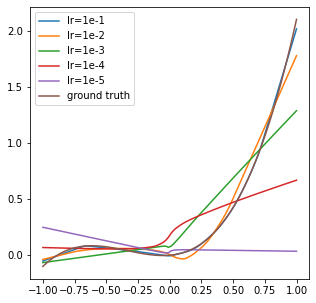

In [12]:
plt.figure(figsize=(5,5))
for idx, lr in enumerate(learning_rate_set):
  plt.plot(x[0,:], prediction_results[idx][0,:], label=f'lr=1e-{idx+1}')
plt.plot(x[0,:],y[0,:],label='ground truth')
plt.legend()
plt.show()

### 2.4 Network Capacity

In [13]:
# train neural networks with different capacities
x, y = create_toy_dataset()
num_neurons_list = [5, 50, 100, 500, 1000]
loss_results = []
prediction_results = []

learning_rate = 0.01
for num_neurons in num_neurons_list:
  print(f'-----number of hidden neurons: {num_neurons:d} ------')
  parameters = initialize_parameters('normal',num_neurons)
  nn = NeuralNetwork(parameters,learning_rate,step=500)
  start = time()
  nn.train(x,y,epochs=5000,minibatch_num=10)
  end = time()
  loss_results.append(nn.loss_log)
  prediction_results.append(nn.predict(x))
  print(f'training time is {end-start}\n')

-----number of hidden neurons: 5 ------
[epoch 1/5000], loss [1.42190032]
[epoch 500/5000], loss [0.03646465]
[epoch 1000/5000], loss [0.00791119]
[epoch 1500/5000], loss [0.0029532]
[epoch 2000/5000], loss [0.00146597]
[epoch 2500/5000], loss [0.00067348]
[epoch 3000/5000], loss [0.00036487]
[epoch 3500/5000], loss [0.00022196]
[epoch 4000/5000], loss [0.00014759]
[epoch 4500/5000], loss [0.00010681]
[epoch 5000/5000], loss [8.92731794e-05]
training time is 4.997457504272461

-----number of hidden neurons: 50 ------
[epoch 1/5000], loss [1.39636643]
[epoch 500/5000], loss [0.10484236]
[epoch 1000/5000], loss [0.07815245]
[epoch 1500/5000], loss [0.06193243]
[epoch 2000/5000], loss [0.04970879]
[epoch 2500/5000], loss [0.04014545]
[epoch 3000/5000], loss [0.03254729]
[epoch 3500/5000], loss [0.0264673]
[epoch 4000/5000], loss [0.02169372]
[epoch 4500/5000], loss [0.01792075]
[epoch 5000/5000], loss [0.01510128]
training time is 5.63236403465271

-----number of hidden neurons: 100 -----

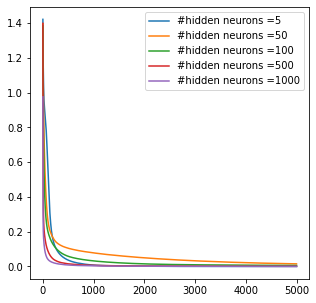

In [14]:
# visualize the results
plt.figure(figsize=(5,5))
for idx, num_neurons in enumerate(num_neurons_list):
  plt.plot(loss_results[idx], label=f'#hidden neurons ={num_neurons}')
plt.legend()
plt.show()

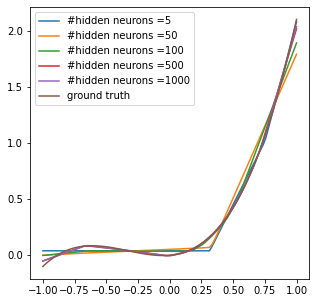

In [15]:
plt.figure(figsize=(5,5))
for idx, num_neurons in enumerate(num_neurons_list):
    plt.plot(x[0,:], prediction_results[idx][0,:], label=f'#hidden neurons ={num_neurons}')
plt.plot(x[0,:],y[0,:],label='ground truth')
plt.legend()
plt.show()

### 2.5 Regularization

In [16]:
class NeuralNetwork_with_regulation(NeuralNetwork):
    def __init__(self, parameters, learning_rate, step):
        super().__init__(parameters[0:-1],learning_rate,step)
        self.decay = parameters[-1]
        
        # You can modify here to add the gradients for the regularization terms
    def train(self, x, y, epochs=5000, minibatch_num=1):
        x_, y_ = x.reshape(minibatch_num,1,-1), y.reshape(minibatch_num,1,-1)
        loss = 0
        for i in range(epochs):
          for x,y in zip(x_,y_):
            y_hat = forward_pass(x,self.w1,self.b1,self.w2,self.b2)
            loss = 1/y.shape[1]*(mse(y, y_hat))
            gradient = cal_gradient(x,y,y_hat,self.w1,self.b1,self.w2,self.b2)
            regul_w1 = 2*self.decay*self.w1
            regul_w2 = 2*self.decay*self.w2
            self.w1 = update_parameters(self.w1,gradient[0]+regul_w1,self.learning_rate)
            self.b1 = update_parameters(self.b1,gradient[1],self.learning_rate)
            self.w2 = update_parameters(self.w2,gradient[2]+regul_w2,self.learning_rate)
            self.b2 = update_parameters(self.b2,gradient[3],self.learning_rate)
          self.loss_log.append(loss)
          if(i==0 or (i+1)%self.step == 0):
            print(f'[epoch {i+1}/{epochs}], loss {loss}')

In [17]:
# train neural networks with different decays
x, y = create_toy_dataset(200)
decay_list = [np.power(0.1,i+1) for i in range(5)]
loss_results = []
prediction_results = []

learning_rate = 0.01
for decay in decay_list:
  print(f'-----decay is : {decay:.5f} ------')
  parameters = initialize_parameters('normal',num_neurons)
  parameters = list(parameters)
  parameters.append(decay)
  nn = NeuralNetwork_with_regulation(parameters,learning_rate,step=500)
  start = time()
  nn.train(x,y,epochs=5000,minibatch_num=10)
  end = time()
  loss_results.append(nn.loss_log)
  prediction_results.append(nn.predict(x))
  print(f'training time is {end-start}\n')

-----decay is : 0.10000 ------
[epoch 1/5000], loss [0.96555205]
[epoch 500/5000], loss [0.77012908]
[epoch 1000/5000], loss [0.77487459]
[epoch 1500/5000], loss [0.77565318]
[epoch 2000/5000], loss [0.77575093]
[epoch 2500/5000], loss [0.77568935]
[epoch 3000/5000], loss [0.77561797]
[epoch 3500/5000], loss [0.77555118]
[epoch 4000/5000], loss [0.77561708]
[epoch 4500/5000], loss [0.77568209]
[epoch 5000/5000], loss [0.77561722]
training time is 35.55425429344177

-----decay is : 0.01000 ------
[epoch 1/5000], loss [0.95410544]
[epoch 500/5000], loss [0.09343258]
[epoch 1000/5000], loss [0.10016297]
[epoch 1500/5000], loss [0.09708548]
[epoch 2000/5000], loss [0.09620546]
[epoch 2500/5000], loss [0.09556911]
[epoch 3000/5000], loss [0.09504014]
[epoch 3500/5000], loss [0.09459629]
[epoch 4000/5000], loss [0.09421725]
[epoch 4500/5000], loss [0.09388899]
[epoch 5000/5000], loss [0.09360213]
training time is 35.6587119102478

-----decay is : 0.00100 ------
[epoch 1/5000], loss [0.952948

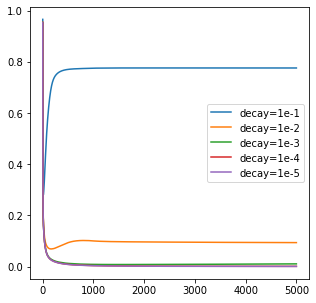

In [18]:
# visualize the results
plt.figure(figsize=(5,5))
for idx,decay in enumerate(decay_list):
  plt.plot(loss_results[idx], label=f'decay=1e-{idx+1}')
plt.legend()
plt.show()

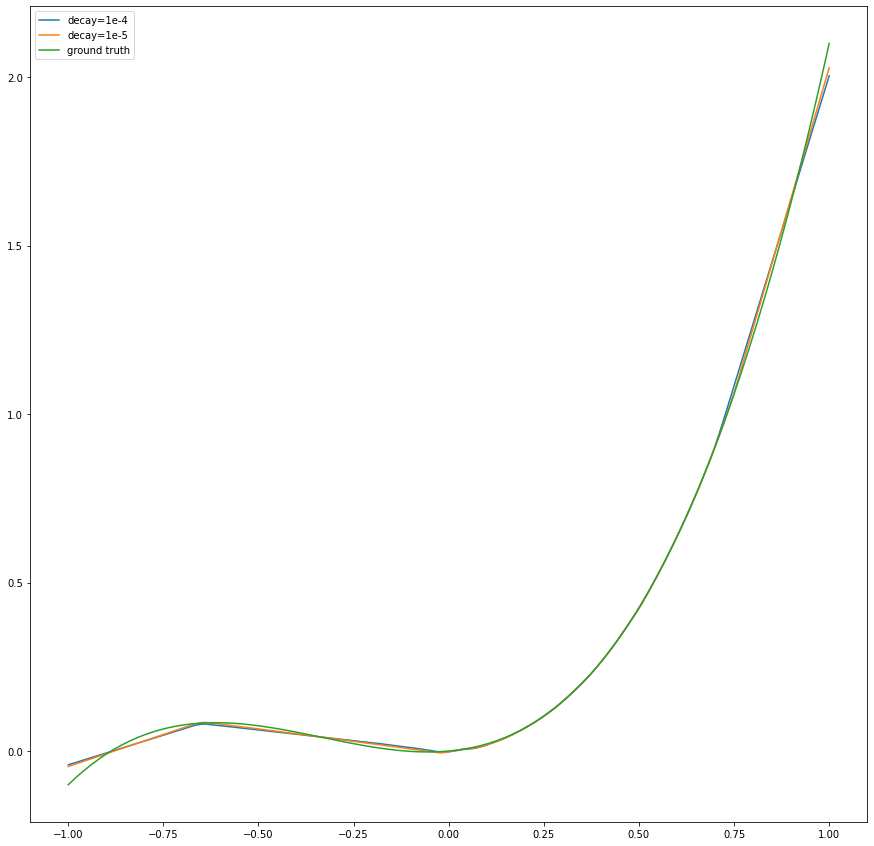

In [21]:
plt.figure(figsize=(15,15))
for idx, decay in enumerate(decay_list):
  if idx > 2:
    plt.plot(x[0,:],prediction_results[idx][0,:], label=f'decay=1e-{idx+1}')
plt.plot(x[0,:],y[0,:],label='ground truth')
plt.legend()
plt.show()